In [1]:
import pandas as pd
import os
from sqlalchemy import create_engine
import sqlite3
from clean_data import carregar_dados, padronizar_dados, padronizar_binarios, tratar_datas, criar_faixa_etaria,tratar_respostas_multiescolha
from analyze_data import (
    analisar_dados,
    distribuicao_variaveis_categoricas,
    verificar_outliers,
    tratar_outliers,
    verificar_datas,
    verificar_duplicatas,
    correlacao_variaveis_numericas,
    cruzar_variaveis,
    agregar_dados
)

from analyze_data import calcular_limites_iqr



In [2]:
# Carregar DataFrame 
caminho_arquivo = r"C:\Users\saman\Documents\teste_DIT\data\dados_ficha_a_desafio.csv"  # ou outro caminho para um arquivo .json, .xlsx, .parquet
df = carregar_dados(caminho_arquivo)

In [25]:
df.head()

,id_paciente,sexo,obito,bairro,raca_cor,ocupacao,religiao,luz_eletrica,data_cadastro,escolaridade,...,familia_beneficiaria_auxilio_brasil,crianca_matriculada_creche_pre_escola,altura,peso,pressao_sistolica,pressao_diastolica,n_atendimentos_atencao_primaria,n_atendimentos_hospital,updated_at,tipo
0,cd6daa6e-038d-4952-af29-579e62e07f97,male,0,Parada de Lucas,Branca,Não se aplica,Sem religião,True,2021-06-24 00:00:00.000,Fundamental Incompleto,...,0,0,172.0,52.5,110.0,70.0,8,9,2021-06-01 00:00:00.000,historico
1,ad6cecb2-3a44-49ab-b2f3-6f9ffc2e2ec7,male,0,Cidade Nova,Parda,Assistente Administrativo,Evangélica,1,2021-01-07 00:00:00.000,Médio Incompleto,...,1,0,158.0,76.2,140.0,80.0,0,6,2020-06-25 00:00:00.000,historico
2,54e834e7-e722-4daa-8909-cf917a1247e6,male,0,Santa cruz,Parda,Não se aplica,Católica,1,2021-02-18 00:00:00.000,Fundamental Completo,...,0,0,53.0,82.5,180.0,60.0,5,2,2020-03-02 00:00:00.000,historico
3,c6a71e5e-0933-48d1-9d5a-8f448dc37f71,female,False,Bangu,Branca,Representante Comercial Autônomo,Sem religião,1,2022-03-09 10:40:37,Alfabetizado,...,1,1,164.0,90.6,120.0,70.0,0,27,2021-11-05 11:08:17.477,rotineiro
4,d5262a3c-e5d3-4195-a46b-0acd2533e1d6,male,0,Santíssimo,Branca,Técnico Eletricista,Outra,True,2022-12-13 18:30:45,Médio Completo,...,0,0,154.0,8.5,180.0,80.0,25,0,2020-11-11 00:00:00.000,historico


#### Limpeza

#### Identificação do Paciente

Considerando que o updated_at seja a data de subida no sistema da Secretaria, a data_cadastro como data da coleta de dados pelo agente e a data_atualizacao_cadastro a data de atualização dos dados da coleta pelo agente de saúde. Visto isso e observando os dados temos que existe uma desafagem dos dados em relação ao cadastro e o inicio da subida dos dados nos sistema da Secretaria.

  - Contém 99.000 valores únicos em 100.000 registros, indicando que há 1.000 IDs duplicados. Analisando apenas os dados duplicados observa-se um comportamento de criação de cadastro com chave duplicada que teve um erro ao entrar os dados e nas atualizações. Para analise os dados duplicados foram separados para tratamento posterior e entender com mais detalhe os dados. Foi considerado os duplicados com cadastro mais recente.

- Erro de preenchimento em colunas de data: data_cadastro,data_atualizacao_cadastro, update_at. Além de ter erros tipo default em 'data_atualizacao_cadastro','updated_at' que foram exckuidos da análiseem torno de 

- Colunas com dados binários com erros,podendo ter surgindo a longo do tempo devido aformade coleta de dados
- Colunas como religião, raca/cor, identidade de genero com valores diferentes da categoria demonstrando algum erro ao concatenar dados.
- Colunas com respostas multiescolha tem erro de palavras sinal e que parece tambémter sido na transferencia ou junção de dados atuaisa com dados antigos. As mesmas foram tratadas deforma que cada categoriade respostar se torunou um coluna binária para facilitar a análise

- crianca_matriculada_creche_pre_escola, tem erros de preenchimentos quanto a ciranças e adultos receberem verdadeiro para essa variavel. Será excluida da análise.

In [3]:
colunas_datas = ['data_cadastro','data_atualizacao_cadastro','updated_at']

In [4]:
df  = tratar_datas(df,colunas_datas)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
C:\Users\saman\Documents\teste_DIT\src\clean_data.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[coluna] = pd.to_datetime(df[coluna], errors='coerce')


Total de datas com erro '1900-01-01 00:00:00': 0
Total de datas com erro '2210-07-15 18:16:26': 0


In [5]:
verificar_datas(df,colunas_datas)

{'data_cadastro': (Timestamp('2012-12-26 00:00:00'),
  Timestamp('2025-02-10 12:00:06')),
 'data_atualizacao_cadastro': (Timestamp('2012-11-29 00:00:00'),
  Timestamp('2025-02-10 12:59:06')),
 'updated_at': (Timestamp('2014-05-21 00:00:00'),
  Timestamp('2025-02-10 11:38:09'))}

In [6]:
comparacao_datas = df[["data_cadastro", "data_atualizacao_cadastro", "updated_at",'tipo']].describe()
comparacao_datas

,data_cadastro,data_atualizacao_cadastro,updated_at,tipo
count,97934,97934,97934,97934
unique,68916,76516,55805,2
top,2017-07-30 00:00:00,2021-03-23 00:00:00,2020-07-28 00:00:00,historico
freq,106,61,323,90332
first,2012-12-26 00:00:00,2012-11-29 00:00:00,2014-05-21 00:00:00,NaN
last,2025-02-10 12:00:06,2025-02-10 12:59:06,2025-02-10 11:38:09,NaN


In [7]:
colunas= ['tipo']
distribuicao_variaveis_categoricas(df,colunas)


Distribuição de tipo:
historico    90332
rotineiro     7602
Name: tipo, dtype: int64


In [8]:
id_duplicados = pd.DataFrame(df['id_paciente'].value_counts())
id_duplicados.rename(columns={'id_paciente': 'duplicados'},inplace=True)

In [10]:
df = df.merge(id_duplicados ,left_on='id_paciente', right_on=id_duplicados.index, how='left')

In [11]:
id_duplicados = pd.DataFrame(df[df['duplicados'] > 1]) 
id_duplicados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1900 entries, 15 to 97880
Data columns (total 37 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   id_paciente                            1900 non-null   object        
 1   sexo                                   1900 non-null   object        
 2   obito                                  1900 non-null   object        
 3   bairro                                 1900 non-null   object        
 4   raca_cor                               1900 non-null   object        
 5   ocupacao                               1900 non-null   object        
 6   religiao                               1900 non-null   object        
 7   luz_eletrica                           1900 non-null   object        
 8   data_cadastro                          1900 non-null   datetime64[ns]
 9   escolaridade                           1900 non-null   object

In [12]:
comparacao_datas =id_duplicados[["data_cadastro", "data_atualizacao_cadastro", "updated_at",'tipo']].describe()
comparacao_datas

,data_cadastro,data_atualizacao_cadastro,updated_at,tipo
count,1900,1900,1900,1900
unique,1704,1839,1630,2
top,2021-04-13 00:00:00,2021-07-27 00:00:00,2020-07-23 00:00:00,historico
freq,5,4,10,1756
first,2015-12-11 00:00:00,2016-07-27 12:00:00,2016-12-22 00:00:00,NaN
last,2025-02-07 02:24:54,2025-02-03 04:19:11,2025-02-04 01:13:55,NaN


In [77]:
# Ordenar os dados pela coluna 'id_paciente' e 'data_cadastro' para obter os registros mais recentes
df_sorted = df.sort_values(by=['id_paciente', 'data_cadastro'], ascending=[True, False])
# Manter apenas os registros mais recentes para cada id_paciente com base na data_cadastro
df_limpo = df_sorted .drop_duplicates(subset=['id_paciente'], keep='first')
df_limpo['id_paciente'].value_counts()

b7d73ea7-2725-4d80-bf54-c6efc9bd4708    1
d7ffca30-d604-468f-9eb2-73eda2318e4b    1
02aac8bf-fbe8-4cad-bd76-6e3058743acc    1
05d72dc2-de0a-4add-9588-8d3387f148b7    1
60a2b27f-4062-4217-820e-1c565cd4ed8d    1
                                       ..
77ed764d-6cbf-4ae0-9c61-0950a0b7c400    1
aff7bcc9-e42e-40e7-b248-4d81bcc508f8    1
8d1b4e06-dcbe-4942-b562-2e69195dfe37    1
e646e118-b8b5-42cf-937f-00e4abe90f77    1
94d2d564-066c-41f3-9197-994fc94fbe36    1
Name: id_paciente, Length: 96981, dtype: int64

Tratamento das variaveis

In [78]:
categorias = ['Branca', 'Parda', 'Preta', 'Amarela','Indígena']
df_limpo = padronizar_dados(df_limpo, 'raca_cor',categorias)

In [82]:
df_limpo['identidade_genero'].fillna('0',inplace=True)

In [85]:
df_limpo['identidade_genero'].unique()

array(['Não', 'Heterossexual', 'Cis', 'Mulher transexual',
       'Homem transexual', 'Outro', 'Travesti',
       'Homossexual (gay / lésbica)', 'Bissexual'], dtype=object)

In [60]:
df_limpo = criar_faixa_etaria(df_limpo,'data_nascimento')

C:\Users\saman\Documents\teste_DIT\src\clean_data.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[coluna_data_nascimento] = pd.to_datetime(df[coluna_data_nascimento], format=formato, errors='coerce')


In [84]:
categoria = ['Cis', 'Outro', 'Homem transexual', 'Mulher transexual',
       'Heterossexual', 'Homossexual (gay / lésbica)', 'Bissexual',
       'Travesti']
df_limpo = padronizar_dados(df_limpo, 'identidade_genero',categoria)

In [86]:
df_limpo['identidade_genero'].value_counts()

Não                            68686
Cis                            20359
Mulher transexual               3683
Homem transexual                1880
Outro                           1298
Heterossexual                    993
Homossexual (gay / lésbica)       43
Travesti                          33
Bissexual                          6
Name: identidade_genero, dtype: int64

In [87]:
categoria =[ '3 Salários Mínimos', '2 Salários Mínimos', '1 Salário Mínimo',
       '1/2 Salário Mínimo', '4 Salários Mínimos',
       'Mais de 4 Salários Mínimos', '1/4 Salário Mínimo']

df_limpo = padronizar_dados(df_limpo, 'renda_familiar',categoria)

In [88]:
categoria = ['Desempregado', 'Emprego Formal',
       'Autônomo com previdência social', 'Não se aplica',
       'Emprego Informal', 'Pensionista / Aposentado', 'Autônomo',
       'Outro', 'Não trabalha', 'Empregador',
       'Autônomo sem previdência social']
df_limpo = padronizar_dados(df_limpo, 'situacao_profissional',categoria)

In [112]:
df_limpo = pd.DataFrame(criar_faixa_etaria(df_limpo, 'data_nascimento'))

C:\Users\saman\Documents\teste_DIT\src\clean_data.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[coluna_data_nascimento] = pd.to_datetime(df[coluna_data_nascimento], format=formato, errors='coerce')


In [89]:
categoria = ['Católica', 'Evangélica', 'Sem religião', 'Espírita', 'Outra',
       'Religião de matriz africana','Judaísmo', 'Budismo',
        'Islamismo']
df_limpo = padronizar_dados(df_limpo, 'religiao',categoria)

In [90]:
df_limpo = padronizar_binarios(df_limpo,'possui_plano_saude')
df_limpo = padronizar_binarios(df_limpo,'em_situacao_de_rua')
df_limpo = padronizar_binarios(df_limpo,'luz_eletrica')
df_limpo = padronizar_binarios(df_limpo,'vulnerabilidade_social')
df_limpo = padronizar_binarios(df_limpo,'obito')
df_limpo = padronizar_binarios(df_limpo,'familia_beneficiaria_auxilio_brasil')
df_limpo = padronizar_binarios(df_limpo,'crianca_matriculada_creche_pre_escola')

C:\Users\saman\Documents\teste_DIT\src\clean_data.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[coluna] = df[coluna].astype(str).str.strip().map(lambda x: mapeamento.get(x, x)).astype(int)


In [91]:
tratar_respostas_multiescolha(df_limpo,  'meios_transporte')
tratar_respostas_multiescolha(df_limpo,  'meios_comunicacao')
tratar_respostas_multiescolha(df_limpo,  'doencas_condicoes')
tratar_respostas_multiescolha(df_limpo,  'em_caso_doenca_procura')


C:\Users\saman\Documents\teste_DIT\src\clean_data.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[coluna] = df[coluna].apply(limpar_resposta)
C:\Users\saman\Documents\teste_DIT\src\clean_data.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[opcao] = df[coluna].apply(lambda x: 1 if opcao in x else 0)


,id_paciente,sexo,obito,bairro,raca_cor,ocupacao,religiao,luz_eletrica,data_cadastro,escolaridade,...,Diabetes,Tabagismo,Tentativa de Suicídio,Gestante,Farmácia,Rede Privada,Hospital Público,Auxílio Espiritual,Unidade de Saúde,1 Salário Mínimo
6371,0000531b-16b4-4080-9466-61d25d223b7b,male,0,Cachambi,Parda,Não se aplica,Católica,1,2022-08-02 17:25:32,Médio Completo,...,0,0,0,0,0,0,1,0,0,0
39013,0000ce2e-0fe7-487c-bcc4-df816d4f341c,female,0,Campo Grande,Branca,Manicure,Evangélica,1,2024-04-02 23:03:48,Médio Completo,...,0,0,0,0,0,0,1,0,1,0
36941,0000fc1a-ff20-4b42-be29-0a11acf699f1,female,0,Santa Rosa,Parda,Vigilante,Sem religião,1,2022-05-22 10:29:31,Médio Completo,...,0,0,0,0,0,1,1,0,1,0
84651,0001721d-118a-4549-9a08-4405e9b7d21d,male,0,Copacabana,Parda,Professor de Disciplinas Pedagógicas No Ensino...,Evangélica,1,2023-01-17 12:10:11,Alfabetizado,...,0,0,0,0,0,0,1,0,1,0
57912,00029b27-c888-458a-a867-a534d9d386da,female,0,Realengo,Preta,Não se aplica,Espírita,1,2023-07-15 14:19:55,Não sabe ler/escrever,...,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54757,fffed6a2-6bcb-4f22-8624-d786024dcdc6,female,0,Colégio,Parda,Não se aplica,Outra,1,2021-07-15 11:50:34,Médio Completo,...,0,0,0,0,0,0,1,0,0,0
13435,fffee3bb-4845-4488-9dbf-9f8a89618c1b,female,0,Vigário Geral,Parda,Técnico Em Eletromecânica,Outra,1,2021-06-15 00:00:00,Não sabe ler/escrever,...,1,0,0,0,0,0,1,0,1,0
69571,fffee3f5-05e9-4196-afbd-9f0faf051da0,female,0,Santa cruz,Parda,Tecnólogo em secretariado escolar,Outra,1,2022-08-23 19:49:26,Fundamental Incompleto,...,0,0,0,0,0,0,1,0,0,0
87561,ffff006a-b49c-40d2-96ec-5d3ff8a08aef,female,0,Senador Camará,Parda,Impressor (serigrafia),Evangélica,1,2021-05-02 10:05:06,Fundamental Incompleto,...,0,0,0,0,0,0,0,0,0,0


In [159]:
df_limpo.drop(['Manhã','zeros','1 Salário Mínimo', '3 Salários Mínimos','Mais de 4 Salários Mínimos','4 Salários Mínimos'],axis=1,inplace=True)

 ### Analise

#### Identificação Paciente

In [95]:
id_paciente = pd.DataFrame(df_limpo, columns=['id_paciente','data_cadastro','data_atualizacao_cadastro','updated_at', 'tipo'])

In [96]:
colunas = ['id_paciente','tipo']

In [97]:
distribuicao_variaveis_categoricas(id_paciente,colunas,plot=False)


Distribuição de id_paciente:
b7d73ea7-2725-4d80-bf54-c6efc9bd4708    1
d7ffca30-d604-468f-9eb2-73eda2318e4b    1
02aac8bf-fbe8-4cad-bd76-6e3058743acc    1
05d72dc2-de0a-4add-9588-8d3387f148b7    1
60a2b27f-4062-4217-820e-1c565cd4ed8d    1
                                       ..
77ed764d-6cbf-4ae0-9c61-0950a0b7c400    1
aff7bcc9-e42e-40e7-b248-4d81bcc508f8    1
8d1b4e06-dcbe-4942-b562-2e69195dfe37    1
e646e118-b8b5-42cf-937f-00e4abe90f77    1
94d2d564-066c-41f3-9197-994fc94fbe36    1
Name: id_paciente, Length: 96981, dtype: int64

Distribuição de tipo:
historico    89448
rotineiro     7533
Name: tipo, dtype: int64


In [105]:
id_paciente['Mes_cadastro'] = id_paciente['data_cadastro'].dt.strftime('%m-%Y')
id_paciente['Mes_cadastro_atualizacao'] = id_paciente['data_atualizacao_cadastro'].dt.strftime('%m-%Y')
id_paciente['Mes_cadastro_updated_at'] = id_paciente['updated_at'].dt.strftime('%m-%Y')

In [107]:
id_paciente['Mes_cadastro'].value_counts()

08-2021    2827
01-2022    2640
07-2021    2602
06-2022    2599
06-2021    2499
           ... 
05-2015       1
03-2013       1
12-2012       1
02-2016       1
01-2015       1
Name: Mes_cadastro, Length: 105, dtype: int64

#### Caracteristicas Demográficas

In [115]:
caract_demo = pd.DataFrame(df_limpo, columns=['id_paciente','sexo','raca_cor', 'identidade_genero','orientacao_sexual','nacionalidade',
                                         'data_nascimento','faixa_etaria' ])

In [116]:
colunas = ['sexo','raca_cor', 'identidade_genero','orientacao_sexual','nacionalidade','faixa_etaria']

In [117]:
distribuicao_variaveis_categoricas(caract_demo,colunas,plot=False)


Distribuição de sexo:
female    53811
male      43170
Name: sexo, dtype: int64

Distribuição de raca_cor:
Parda       49272
Branca      34103
Preta       11037
Amarela      2534
Indígena       35
Name: raca_cor, dtype: int64

Distribuição de identidade_genero:
Não                            68686
Cis                            20359
Mulher transexual               3683
Homem transexual                1880
Outro                           1298
Heterossexual                    993
Homossexual (gay / lésbica)       43
Travesti                          33
Bissexual                          6
Name: identidade_genero, dtype: int64

Distribuição de orientacao_sexual:
Heterossexual                  91016
Homossexual (gay / lésbica)     4001
Outro                           1271
Bissexual                        693
Name: orientacao_sexual, dtype: int64

Distribuição de nacionalidade:
Brasileira      96652
Estrangeiro       297
Naturalizado       32
Name: nacionalidade, dtype: int64

Distribuição

#### Caracteristicas Socioeconomicas

In [181]:
cond_socio = pd.DataFrame(df_limpo,columns=['id_paciente','bairro','renda_familiar','escolaridade','ocupacao',
                                      'situacao_profissional','em_situacao_de_rua','familia_beneficiaria_auxilio_brasil',
                                      'luz_eletrica','frequenta_escola','Metrô', 'Carroça', 'Bicicleta',
       'Animal', 'Caminhão', 'Carro', 'Ônibus', 'Alternativo', 'Outros',
       'Marítimo', 'Trem', 'Rádio', 'Revista', 'Jornal', 'Televisão',
       'Grupos Religiosos', 'Internet',],
                         )

In [138]:
variaveis = ['bairro','renda_familiar','escolaridade','ocupacao',
                                      'situacao_profissional','em_situacao_de_rua','familia_beneficiaria_auxilio_brasil', 'luz_eletrica',
                                'frequenta_escola',]

In [137]:
distribuicao_variaveis_categoricas(cond_socio,variaveis,plot=False)


Distribuição de bairro:
Campo Grande                5695
Santa cruz                  4168
Bangu                       3845
Realengo                    3258
Guaratiba                   2755
                            ... 
Xavantes                       1
Serra Verde (Venda Nova)       1
Jardim Maracanã                1
Parque Ambaí                   1
Prq                            1
Name: bairro, Length: 737, dtype: int64

Distribuição de renda_familiar:
1 Salário Mínimo              42247
2 Salários Mínimos            32385
3 Salários Mínimos             9579
1/2 Salário Mínimo             4682
1/4 Salário Mínimo             3765
4 Salários Mínimos             2767
Mais de 4 Salários Mínimos     1556
Name: renda_familiar, dtype: int64

Distribuição de escolaridade:
Médio Completo               31726
Fundamental Incompleto       21146
Fundamental Completo         13877
Alfabetizado                  8268
Não sabe ler/escrever         7981
Médio Incompleto              6258
Superior co

#### Indicadores de Saude

In [182]:
ind_saude= pd.DataFrame(df_limpo,columns=['id_paciente','obito','possui_plano_saude',
                                   'vulnerabilidade_social','altura','peso','pressao_sistolica','pressao_sistolica',
                                    'n_atendimentos_atencao_primaria','n_atendimentos_hospital', 'AIDS', 'Alcoolismo', 'Epilepsia',
       'Malária', 'Transtorno Mental', 'Sintomático Respiratório',
       'Intern. Psiq. Ult. 12 meses', 'Sintomático Dermatológico', 'Câncer',
       'Def. Visual', 'Usuário de Psicofármacos', 'Asma', 'Def. Mental',
       'Def. Auditiva', 'Hanseníase', 'Violência Doméstica', 'Tuberculose',
       'Hipertensão', 'Usuário de Drogas Ilícitas', 'Def. Física', 'Diabetes',
       'Tabagismo', 'Tentativa de Suicídio', 'Gestante', 'Farmácia',
       'Rede Privada', 'Hospital Público', 'Auxílio Espiritual',
       'Unidade de Saúde'])

In [162]:
df_limpo.columns

Index(['id_paciente', 'sexo', 'obito', 'bairro', 'raca_cor', 'ocupacao',
       'religiao', 'luz_eletrica', 'data_cadastro', 'escolaridade',
       'nacionalidade', 'renda_familiar', 'data_nascimento',
       'em_situacao_de_rua', 'frequenta_escola', 'meios_transporte',
       'doencas_condicoes', 'identidade_genero', 'meios_comunicacao',
       'orientacao_sexual', 'possui_plano_saude', 'em_caso_doenca_procura',
       'situacao_profissional', 'vulnerabilidade_social',
       'data_atualizacao_cadastro', 'familia_beneficiaria_auxilio_brasil',
       'crianca_matriculada_creche_pre_escola', 'altura', 'peso',
       'pressao_sistolica', 'pressao_diastolica',
       'n_atendimentos_atencao_primaria', 'n_atendimentos_hospital',
       'updated_at', 'tipo', 'duplicados', 'Metrô', 'Carroça', 'Bicicleta',
       'Animal', 'Caminhão', 'Carro', 'Ônibus', 'Alternativo', 'Outros',
       'Marítimo', 'Trem', 'Rádio', 'Revista', 'Jornal', 'Televisão',
       'Grupos Religiosos', 'Internet', 'AIDS'

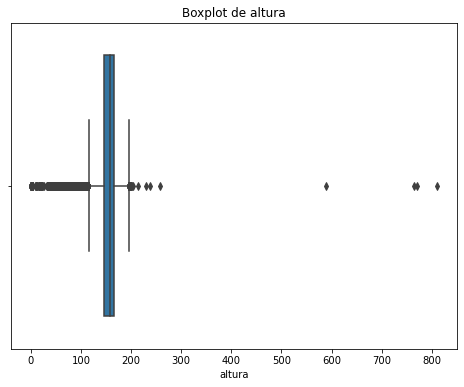

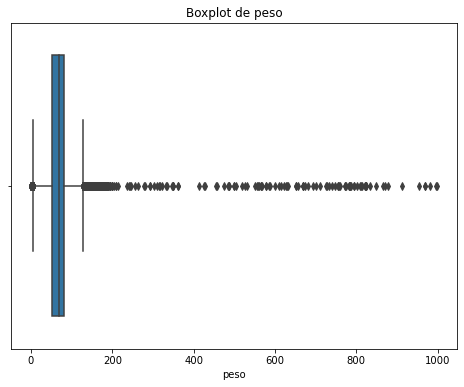

In [151]:
colunas= ['altura', 'peso']
verificar_outliers(df_limpo,colunas)

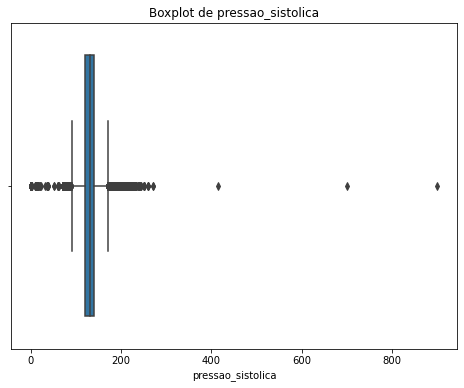

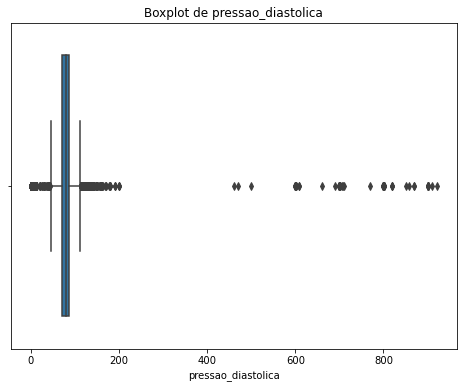

In [146]:
colunas= ['pressao_sistolica', 'pressao_diastolica']

verificar_outliers(df_limpo,colunas)

In [299]:
dado= ['pressao_diastolica']

In [152]:
df_limpo = pd.DataFrame(tratar_outliers(df_limpo, colunas))


In [154]:
df_limpo['peso'].describe()

count    94022.000000
mean        63.475741
std         27.936854
min          3.760000
25%         52.000000
50%         68.000000
75%         81.900000
max        128.900000
Name: peso, dtype: float64

 ### Banco de Dados

In [189]:
# Criar a conexão com o banco de dados SQLite (ele será criado automaticamente se não existir)
conn = sqlite3.connect('dados_ficha_a_desafio.db')
cursor = conn.cursor()

In [177]:
# Criando a tabela id_paciente
cursor.execute('''
CREATE TABLE IF NOT EXISTS id_paciente (
    id_paciente INTEGER PRIMARY KEY,
    data_cadastro TEXT,
    data_atualizacao_cadastro TEXT,
    updated_at TEXT,
    tipo TEXT
);
''')


In [178]:
# Criando a tabela caract_demo
cursor.execute('''
CREATE TABLE IF NOT EXISTS caract_demo (
    id_paciente INTEGER PRIMARY KEY,
    sexo TEXT,
    raca_cor TEXT,
    identidade_genero TEXT,
    orientacao_sexual TEXT,
    nacionalidade TEXT,
    data_nascimento TEXT,
    faixa_etaria TEXT,
    FOREIGN KEY (id_paciente) REFERENCES id_paciente(id_paciente)
);
''')


In [179]:
# Criando a tabela cond_socio
cursor.execute('''
CREATE TABLE IF NOT EXISTS cond_socio (
    id_paciente INTEGER PRIMARY KEY,
    bairro TEXT,
    renda_familiar REAL,
    escolaridade TEXT,
    ocupacao TEXT,
    situacao_profissional TEXT,
    em_situacao_de_rua INTEGER,
    familia_beneficiaria_auxilio_brasil INTEGER,
    luz_eletrica INTEGER,
    frequenta_escola INTEGER,
    Metrô INTEGER,
    Carroça INTEGER,
    Bicicleta INTEGER,
    Animal INTEGER,
    Caminhão INTEGER,
    Carro INTEGER,
    Ônibus INTEGER,
    Alternativo INTEGER,
    Outros INTEGER,
    Marítimo INTEGER,
    Trem INTEGER,
    Rádio INTEGER,
    Revista INTEGER,
    Jornal INTEGER,
    Televisão INTEGER,
    Grupos_Religiosos INTEGER,
    Internet INTEGER,
    FOREIGN KEY (id_paciente) REFERENCES id_paciente(id_paciente)
);
''')


In [170]:
# Criando a tabela ind_saude
cursor.execute('''
CREATE TABLE IF NOT EXISTS ind_saude (
    id_paciente INTEGER PRIMARY KEY,
    obito INTEGER,
    possui_plano_saude INTEGER,
    vulnerabilidade_social TEXT,
    altura REAL,
    peso REAL,
    pressao_sistolica INTEGER,
    pressao_diastolica INTEGER,
    n_atendimentos_atencao_primaria INTEGER,
    n_atendimentos_hospital INTEGER,
    AIDS INTEGER,
    Alcoolismo INTEGER,
    Epilepsia INTEGER,
    Malária INTEGER,
    Transtorno_Mental INTEGER,
    Sintomático_Respiratório INTEGER,
    Intern_Psiq_Ult_12_meses INTEGER,
    Sintomático_Dermatológico INTEGER,
    Câncer INTEGER,
    Def_Visual INTEGER,
    Usuario_de_Psicofármacos INTEGER,
    Asma INTEGER,
    Def_Mental INTEGER,
    Def_Auditiva INTEGER,
    Hanseníase INTEGER,
    Violência_Doméstica INTEGER,
    Tuberculose INTEGER,
    Hipertensão INTEGER,
    Usuario_de_Drogas_Ilícitas INTEGER,
    Def_Física INTEGER,
    Diabetes INTEGER,
    Tabagismo INTEGER,
    Tentativa_de_Suicídio INTEGER,
    Gestante INTEGER,
    Farmácia INTEGER,
    Rede_Privada INTEGER,
    Hospital_Público INTEGER,
    Auxílio_Espiritual INTEGER,
    Unidade_de_Saúde INTEGER,
    FOREIGN KEY (id_paciente) REFERENCES id_paciente(id_paciente)
);
''')

In [180]:
# Commit para salvar as alterações
conn.commit()

# Fechar a conexão
conn.close()

In [183]:
# Definir a URL de conexão com o banco de dados SQLite
db_url = 'sqlite:///dados_ficha_a_desafio.db'


In [184]:
# Criar conexão com o banco usando SQLAlchemy
engine = create_engine(db_url)


In [185]:
# Carregar os dados nas tabelas SQLite
cond_socio.to_sql('cond_socio', engine, if_exists='replace', index=False)
ind_saude.to_sql('ind_saude', engine, if_exists='replace', index=False)
id_paciente.to_sql('id_paciente', engine, if_exists='replace', index=False)
caract_demo.to_sql('caract_demo', engine, if_exists='replace', index=False)
